# Лабораторна робота № 7                                                                                                   

Виконав <br>
студент ФБ-24 <br> 
Демченко Олександр <br>

<b>Сценарії обробки багатоспектральних супутникових зображень</b>

<b>Мета роботи:</b> ознайомитися з основними принципами обробки даних
дистанційного зондування Землі (ДЗЗ) та можливостями мови Python для
обробки геопросторової інформації, а саме, багатоспектральних
супутникових зображень засобами бібліотеки абстракції супутникової
інформації (GDAL).<br>
<b>Основні поняття:</b> дані ДЗЗ (remote sensing data), супутникові зображення
(satellite imagery), обробка зображень (image processing).

==========================================================================================================================================================================

# Постановка задачі

Лабораторна робота має дві частини. У першій (простішій) частині (пп. 1–
2) необхідно працювати з даними Sentinel-2, які необхідно завантажити за
допомогою Copernicus Scihub за ідентифікаторами (список ідентифікаторів
дивись нижче) або скористатися архівом, що надається викладачем. У
другій (складнішій) частині (п. 4) потрібно також самостійно завантажити
дані Landsat з порталу USGS. Для цього підійдуть будь які 2 сусідніх знімки
Ladsat-8 з відсотком хмарності до 30%, (рекомендовані ідентифікатори
наведено внизу у п. 3).

Необхідні пакети для виконання лабортаорної роботи

In [3]:
import os
import logging
import traceback
import subprocess
from pathlib import Path
from typing import List
import glob
from glob import glob
from osgeo import gdal, osr
import geopandas as gpd
import rasterio
from rasterio.plot import show
import pyproj
import numpy as np
from sentinelhub.aws.request import download_safe_format
import sklearn.metrics
import matplotlib.pyplot as plt
import shapely.wkt
import sklearn.metrics
from tqdm import tqdm


print("Setup!")

Setup!


+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

# Sentinel-2

+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

===========================================================================================================================================


<h3>Завдання 1</h3>

===========================================================================================================================================

За допомогою бібліотеки sentinelhub написати скрипт для
завантаження супутникових знімків Sentinel-2, які покривають Київ<br>
<p>
(ROI — POLYGON((29.073321247506765 49.845775018245774,<br>
31.986007792928522 49.845775018245774,<br>
31.986007792928522 51.278667808079206,<br>
29.073321247506765 51.278667808079206,<br>
29.073321247506765 49.845775018245774)))<br>
</p>
Список ідентифікаторів Sentinel-2:<br>
<i>– S2A_MSIL2A_20190821T085601_N0213_R007_T36UUB_20190821T115206<br>
– S2A_MSIL2A_20190821T085601_N0213_R007_T36UUA_20190821T115206</i>

<h3>Code</h3>

In [4]:
logger = logging.getLogger(__name__)
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

def download_data_sentinel_2(product_ids: List[str], directory: str) -> None:
    """
    Завантажує дані з Sentinel-2 з використанням sentinelhub.aws.request.download_safe_format.

    Args:
        product_ids (List[str]): Список ідентифікаторів продуктів Sentinel-2 для завантаження.
        directory (str): Шлях до директорії, куди будуть завантажені дані.

    Returns:
        None
    """
    if not isinstance(product_ids, list):
        raise TypeError("product_ids повинен бути списком рядків")
    if not isinstance(directory, str):
        raise TypeError("directory повинен бути рядком")

    for product_id in product_ids:
        logger.info(f"Завантажуємо {product_id}...")
        try:
            download_safe_format(
                product_id=product_id,
                folder=directory,
                entire_product=True,
                redownload=False
            )
        except Exception as e:
            logger.error(f"Помилка під час завантаження {product_id}: {e}")
            traceback.print_exc()

<h3>Config AWS</h3>
sentinelhub.config --aws_access_key_id <i>Your_access_key_id</i> --aws_secret_access_key <i>Your_secret_key</i>

In [5]:
cmd = "sentinelhub.config --aws_access_key_id <Your_access_key_id> --aws_secret_access_key <Your_secret_key>"

try:
    # Виконати команду
    result = subprocess.run(cmd, shell=True, check=True, capture_output=True, text=True)
    
    # Вивести stdout
    print(result.stdout)
    print("Setup!")
    
    # Вивести stderr, якщо є
    if result.stderr:
        print(result.stderr)
        
except subprocess.CalledProcessError as e:
    # Обробка помилки виконання команди
    print(f"Помилка під час виконання команди: {e}")
    print(e.stdout)
    print(e.stderr)


Setup!


<h3>Product ID set and call function for download data</h3>

In [6]:
# створимо список ідентифікаторів Sentinel-2
product_ids = [
    "S2A_MSIL2A_20190821T085601_N0213_R007_T36UUA_20190821T115206",
    "S2A_MSIL2A_20190821T085601_N0213_R007_T36UUB_20190821T115206",
]
directory = "./method_FIRST"
download_data_sentinel_2(product_ids, directory)

2024-06-04 16:31:11,674 - INFO - Завантажуємо S2A_MSIL2A_20190821T085601_N0213_R007_T36UUA_20190821T115206...
/home/kali/Desktop/data_analysis/Data_Analysis_git/workspace_7/lib/python3.11/site-packages/sentinelhub/aws/request.py:245: SHDeprecationWarning: AWS functionality will remain in the codebase for now, but won't be actively maintained.
  safe_request = AwsProductRequest(product_id, data_folder=folder, bands=bands, safe_format=True)
/home/kali/Desktop/data_analysis/Data_Analysis_git/workspace_7/lib/python3.11/site-packages/sentinelhub/aws/data.py:353: SHDeprecationWarning: AWS functionality will remain in the codebase for now, but won't be actively maintained.
  client = AwsDownloadClient(config=self.config, boto_params=REQUESTER_PAYS_PARAMS)
/home/kali/Desktop/data_analysis/Data_Analysis_git/workspace_7/lib/python3.11/site-packages/sentinelhub/aws/data.py:612: SHDeprecationWarning: AWS functionality will remain in the codebase for now, but won't be actively maintained.
  client 

<h3>Creating .SHP .QPJ .PRJ files from POLYGON Kyiv</h3>

Файли з розширенням .qpj є файлами проєкту QGIS. Вони містять налаштування і параметри, пов'язані з конкретним проєктом QGIS, таким чином зберігаючи стан проєкту для майбутнього використання.

Файли з розширенням .rpj є файлами проектів ArcGIS для настільних систем (ArcView, ArcEditor або ArcInfo). Вони містять інформацію про стан проекту ArcGIS, налаштування відображення даних, налаштування проекції, шляхи до джерел даних та інші параметри, необхідні для відтворення проекту.

.shp - Головний файл, який містить геометричні дані об'єктів (точки, лінії, полігони).<br>
.shx - Індексний файл, який прискорює доступ до геометричних даних в .shp файлі.<br>
.dbf - Файл атрибутів у форматі dBASE, який містить атрибутивні (описові) дані для геометричних об'єктів.

In [59]:
def POLYGON_convert(directory):
    fieldCoordinatesAsTextInWKTInEPSG4326 = "POLYGON((29.073321247506765 49.845775018245774, " \
        "31.986007792928522 49.845775018245774, " \
        "31.986007792928522 51.278667808079206, " \
        "29.073321247506765 51.278667808079206, " \
        "29.073321247506765 49.845775018245774))"

    f = Path.cwd().joinpath(directory)
    if not f.is_dir():
        f.mkdir()

    f_shp = f.joinpath("Kyiv_regions.shp")
    gpd.GeoDataFrame(geometry=[shapely.wkt.loads(fieldCoordinatesAsTextInWKTInEPSG4326)]).to_file(str(f_shp))
    print("Було створено .SHP файл...")

    # Створення файлу .qpj
    f_qpj = f.joinpath("Kyiv_regions.qpj")
    with open(f_qpj, 'w') as qpj_file:
        qpj_file.write('GEOGCRS["WGS 84",DATUM["World Geodetic System 1984",'
                    'ELLIPSOID["WGS 84",6378137,298.257223563,LENGTHUNIT["metre",1]]],PRIMEM["Greenwich",0],'
                    'UNIT["degree",0.0174532925199433],AXIS["Latitude",NORTH],AXIS["Longitude",EAST]]')
    print("Було створено .QPJ файл...")

    # Створення файлу .prj
    f_prj = f.joinpath("Kyiv_regions.prj")
    crs = pyproj.CRS.from_epsg(4326)
    with open(f_prj, 'w') as prj_file:
        prj_file.write(crs.to_wkt())
    print("Було створено .PRJ файл...")

In [60]:
directory = "method_FIRST"
POLYGON_convert(directory)

Було створено .SHP файл...
Було створено .QPJ файл...
Було створено .PRJ файл...


<h3>Task 1 completed, you now have Sentinel-2 satellite data downloaded</h3>

=========================================================================================================================================

<h3>Завдання 2</h3>

=========================================================================================================================================

<h3>– Конкатенація каналів видимого, ближнього та середнього
інфрачервоного спектральних діапазонів (канали 2, 3, 4 та 8) зображення в
єдиний GEOTIFF файл.</h3>

<h3>Code</h3>

In [8]:
def concatenation(directory, concatenated_directory):
    result_dir_concatenation = os.path.join(concatenated_directory, "concatenated")
    if not os.path.exists(result_dir_concatenation):
        os.makedirs(result_dir_concatenation)

    resolutions = [10, 20, 60]
    for resolution in resolutions:
        print(f"Preparing image data for resolution: {resolution}")
        img_path = os.path.join(directory, f"R{resolution}m")

        # Find band paths
        band_2_path = glob(os.path.join(img_path, f"*B02_{resolution}m.jp2"))[0]
        band_3_path = glob(os.path.join(img_path, f"*B03_{resolution}m.jp2"))[0]
        band_4_path = glob(os.path.join(img_path, f"*B04_{resolution}m.jp2"))[0]
        band_8_path = glob(os.path.join(img_path, f"*_*_B*8*_{resolution}m.jp2"))[0]
        bands_path = [band_2_path, band_3_path, band_4_path, band_8_path]

        # Merge bands
        gm = "gdal_merge.py"
        output = os.path.join(result_dir_concatenation, f"output_R{resolution}m.tif")
        merge_command = [gm, "-separate", "-o", output] + bands_path
        subprocess.run(merge_command)
    

<h3>Call method of concatenation</h3>

In [10]:
img_data_MSIL2A_A_path = os.path.join(
    "method_FIRST",
    "S2A_MSIL2A_20190821T085601_N0213_R007_T36UUA_20190821T115206.SAFE",
    "GRANULE",
    "L2A_T36UUA_A021740_20190821T085815",
    "IMG_DATA"
)
img_data_MSIL2A_B_path = os.path.join(
    "method_FIRST",
    "S2A_MSIL2A_20190821T085601_N0213_R007_T36UUB_20190821T115206.SAFE",
    "GRANULE",
    "L2A_T36UUB_A021740_20190821T085815",
    "IMG_DATA"
)
concatenated_directory_A = "concat_L2A_A"
concatenated_directory_B = "concat_L2A_B"

print(product_ids[0])
concatenation(img_data_MSIL2A_A_path, concatenated_directory_A)
print("Concatenation process.....")

print("="*60)

print(product_ids[1])
concatenation(img_data_MSIL2A_B_path, concatenated_directory_B)
print("Concatenation process.....")

S2A_MSIL2A_20190821T085601_N0213_R007_T36UUA_20190821T115206
Preparing image data for resolution: 10
0...10...20...30...40...50...60...70...80...90...100 - done.
Preparing image data for resolution: 20
0...10...20...30...40...50...60...70...80...90...100 - done.
Preparing image data for resolution: 60
0...10...20...30...40...50...60...70...80...90...100 - done.
Concatenation process.....
S2A_MSIL2A_20190821T085601_N0213_R007_T36UUB_20190821T115206
Preparing image data for resolution: 10
0...10...20...30...40...50...60...70...80...90...100 - done.
Preparing image data for resolution: 20
0...10...20...30...40...50...60...70...80...90...100 - done.
Preparing image data for resolution: 60
0...10...20...30...40...50...60...70...80...90...100 - done.
Concatenation process.....


<h3>Show with <i>rasterio</i> and <i>plt</i></h3>

In [13]:
def display_tif_images(directory, cmap='inferno'):
    # Перевірка, чи існує директорія
    if not os.path.exists(directory):
        print(f"Directory '{directory}' does not exist.")
        return
    
    # Проходимо по всіх файлах в директорії
    for filename in os.listdir(directory):
        if filename.endswith('.tif'):
            filepath = os.path.join(directory, filename)
            
            # Відкриття та виведення файлу .tif
            with rasterio.open(filepath) as dataset:
                print(f"Displaying {filename}")
                fig, ax = plt.subplots(figsize=(10, 8))
                img = show(dataset, ax=ax, cmap=cmap)
                
                # Додаємо підпис до картинки
                ax.set_title(f"TIF Image: {filename}")
                
                plt.show()

Displaying output_R10m.tif


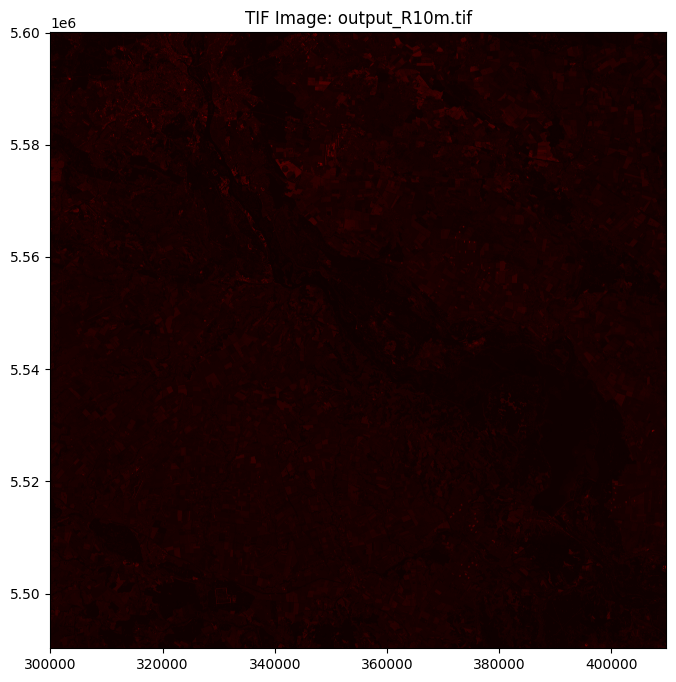

Displaying output_R60m.tif


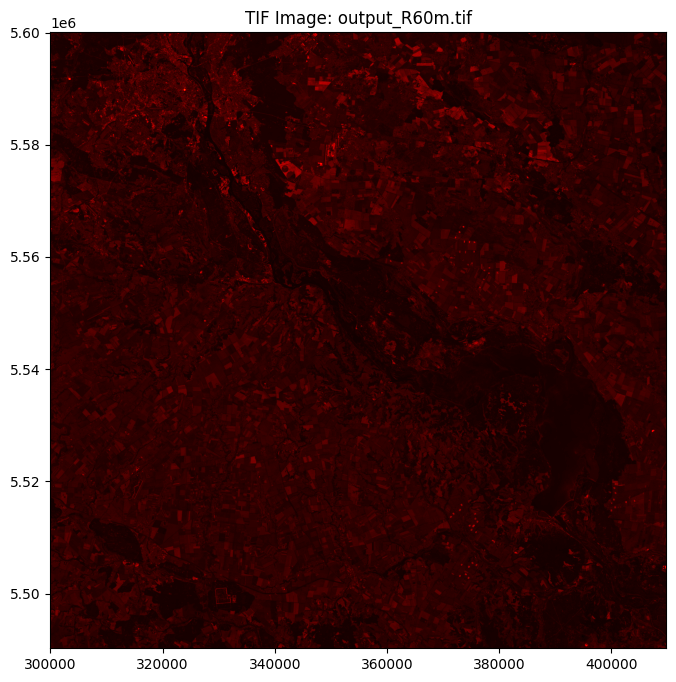

Displaying output_R20m.tif


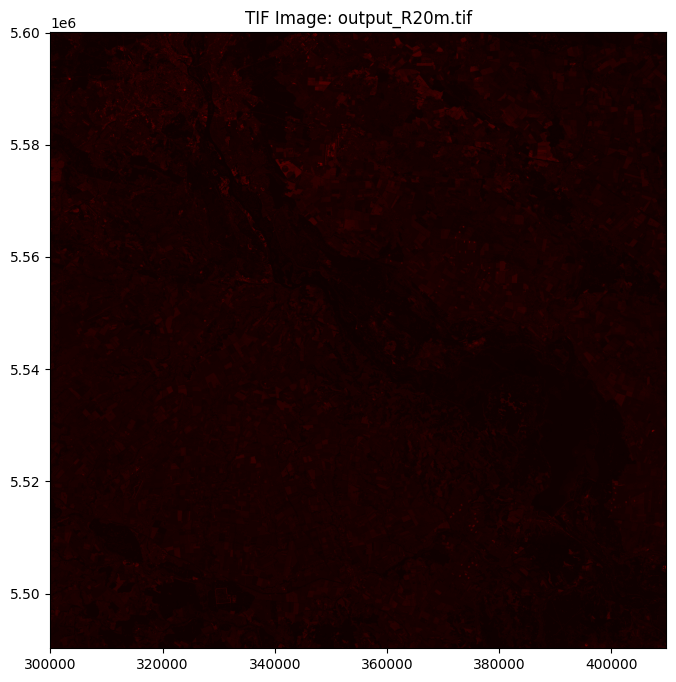

In [14]:
display_tif_images('./concat_L2A_A/concatenated', cmap='hot') 

<h3>This was the first concatenation by identifier <i>S2A_MSIL2A_20190821T085601_N0213_R007_T36UUA_20190821T115206</i></h3>

==================================================================================================================================

Displaying output_R10m.tif


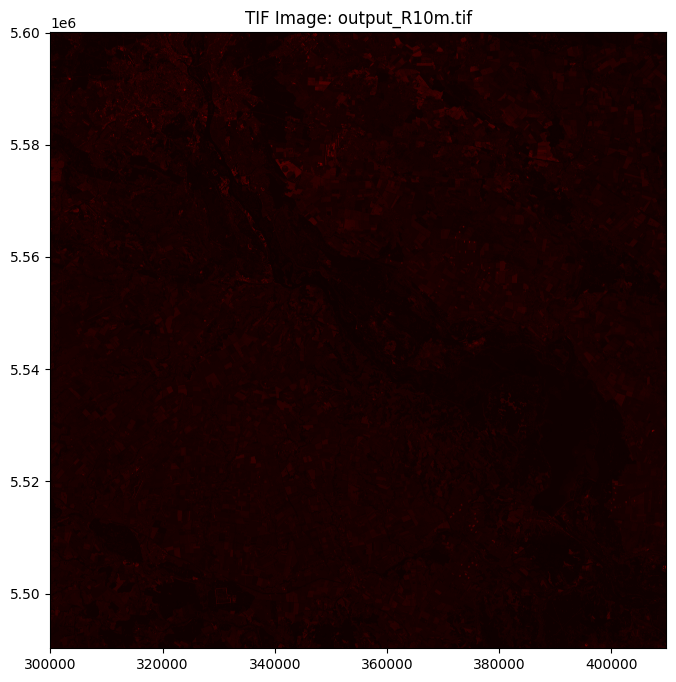

Displaying output_R60m.tif


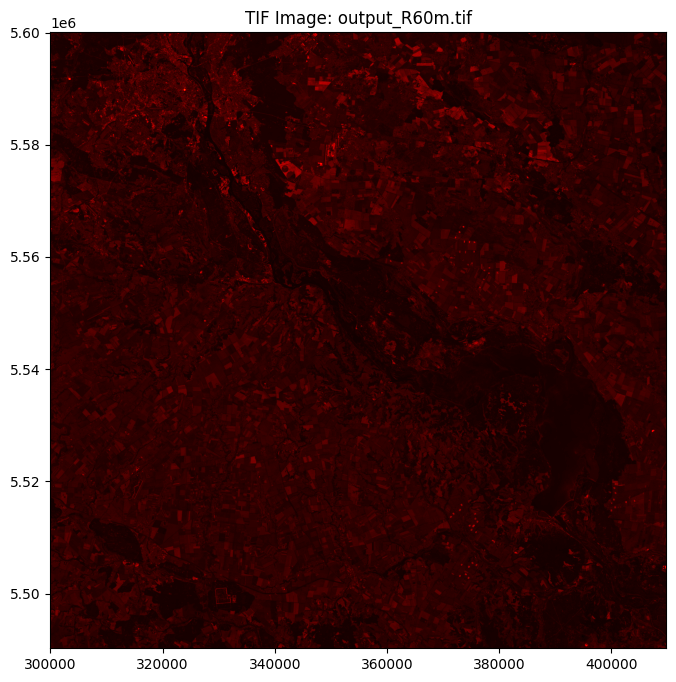

Displaying output_R20m.tif


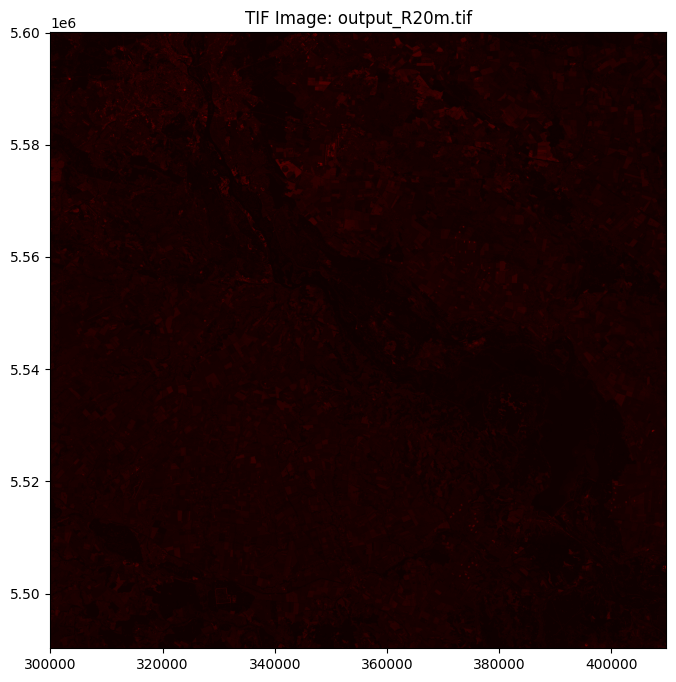

In [15]:
display_tif_images('./concat_L2A_A/concatenated', cmap='hot') 

<h3>This was the second concatenation by identifier <i>S2A_MSIL2A_20190821T085601_N0213_R007_T36UUB_20190821T115206</i></h3>

==================================================================================================================================

<h3>– Перепроектування супутникового зображення у проєкцію 4326.</h3>

In [25]:
def reproject_directory(input_dir, output_dir, target_epsg=4326):
    os.makedirs(output_dir, exist_ok=True)
    
    for filename in tqdm(os.listdir(input_dir), desc="Перепроектування файлів"):
        if filename.endswith((".tif", ".tiff")):
            reproject_to_target(
                os.path.join(input_dir, filename),
                os.path.join(output_dir, filename),
                target_epsg
            )

def reproject_to_target(input_raster, output_raster, target_epsg):
    try:
        with gdal.Open(input_raster) as src_ds:
            src_proj = src_ds.GetProjectionRef()
            
            dst_srs = osr.SpatialReference()
            dst_srs.ImportFromEPSG(target_epsg)
            
            gdal.Warp(output_raster, 
                      src_ds, 
                      dstSRS=dst_srs, 
                      transformerOptions=['SRC_SRS='+src_proj, 'DST_SRS='+dst_srs.ExportToWkt()])
        
        print(f"Перепроектування {input_raster} завершено. Вихідний файл: {output_raster}")
    except Exception as e:
        print(f"Помилка при перепроектуванні {input_raster}: {e}")

In [26]:
# Приклад використання
input_dir = "./concat_L2A_A/concatenated"
output_dir = "./reproject_L2A_A"  # Не обов'язково, якщо потрібно зберігати в тій самій директорії
reproject_directory(input_dir, output_dir)

Перепроектування файлів:  67%|██████▋   | 2/3 [00:04<00:02,  2.02s/it]

Перепроектування ./concat_L2A_A/concatenated/output_R10m.tif завершено. Вихідний файл: ./reproject_L2A_A/output_R10m.tif
Перепроектування ./concat_L2A_A/concatenated/output_R60m.tif завершено. Вихідний файл: ./reproject_L2A_A/output_R60m.tif


Перепроектування файлів: 100%|██████████| 3/3 [00:06<00:00,  2.02s/it]

Перепроектування ./concat_L2A_A/concatenated/output_R20m.tif завершено. Вихідний файл: ./reproject_L2A_A/output_R20m.tif


<h3>Show with <i>rasterio</i> and <i>plt</i></h3>

Displaying output_R10m.tif


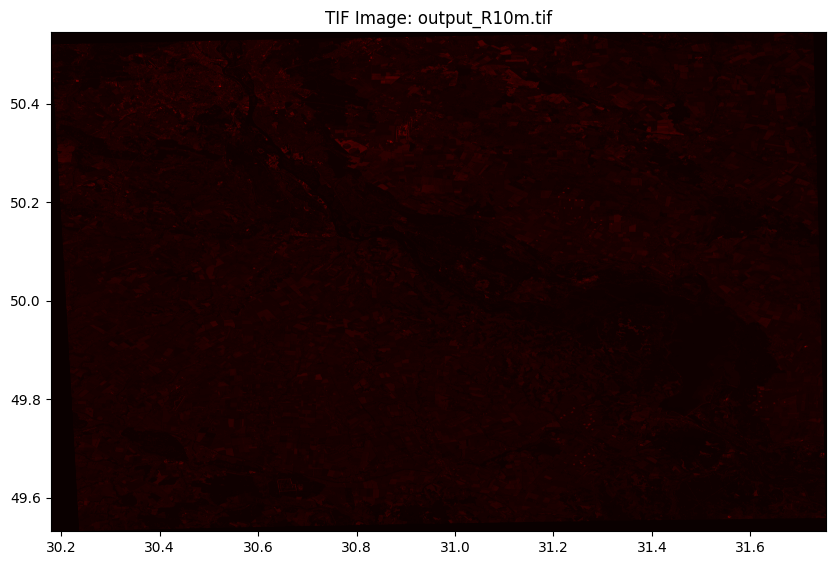

Displaying output_R60m.tif


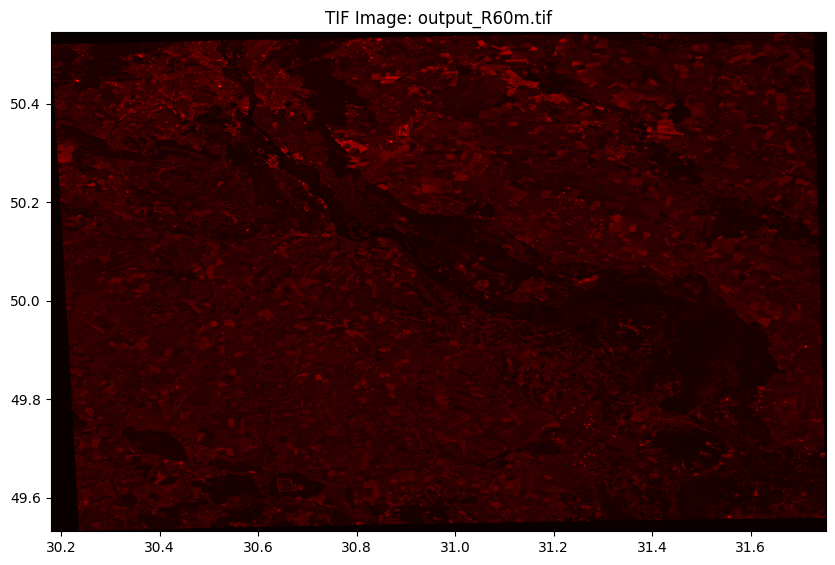

Displaying output_R20m.tif


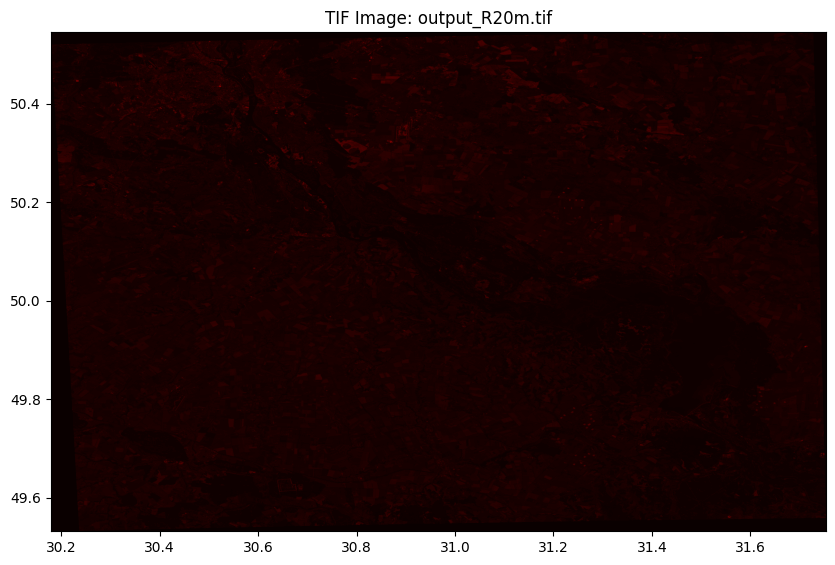

In [27]:
display_tif_images("./reproject_L2A_A", cmap="hot")

<h3>This was the first reprojection by identifier <i>S2A_MSIL2A_20190821T085601_N0213_R007_T36UUA_20190821T115206</i></h3>

===========================================================================================================================================

In [28]:
input_dir = "./concat_L2A_B/concatenated"
output_dir = "./reproject_L2A_B"  
reproject_directory(input_dir, output_dir)

Перепроектування файлів:  33%|███▎      | 1/3 [00:16<00:32, 16.49s/it]

Перепроектування ./concat_L2A_B/concatenated/output_R10m.tif завершено. Вихідний файл: ./reproject_L2A_B/output_R10m.tif


Перепроектування файлів:  67%|██████▋   | 2/3 [00:16<00:07,  7.07s/it]

Перепроектування ./concat_L2A_B/concatenated/output_R60m.tif завершено. Вихідний файл: ./reproject_L2A_B/output_R60m.tif


Перепроектування файлів: 100%|██████████| 3/3 [00:20<00:00,  6.98s/it]

Перепроектування ./concat_L2A_B/concatenated/output_R20m.tif завершено. Вихідний файл: ./reproject_L2A_B/output_R20m.tif


<h3>Show with <i>rasterio</i> and <i>plt</i></h3>

Displaying output_R10m.tif


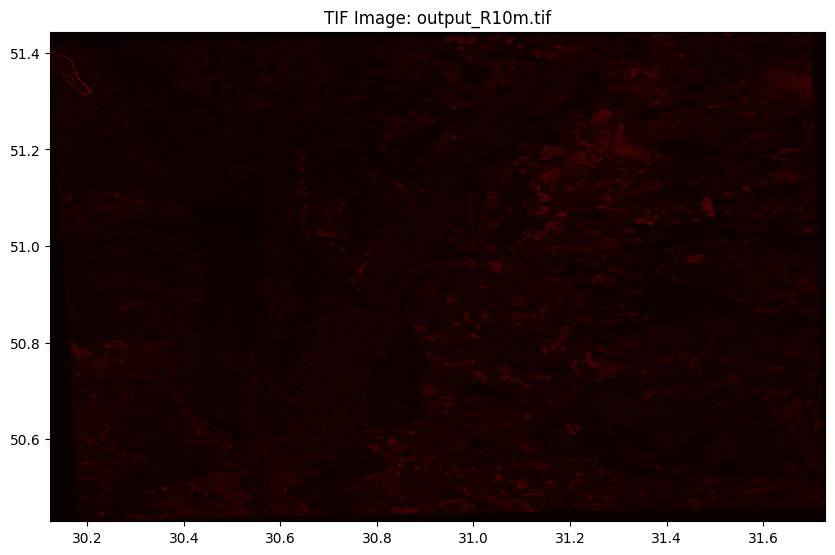

Displaying output_R60m.tif


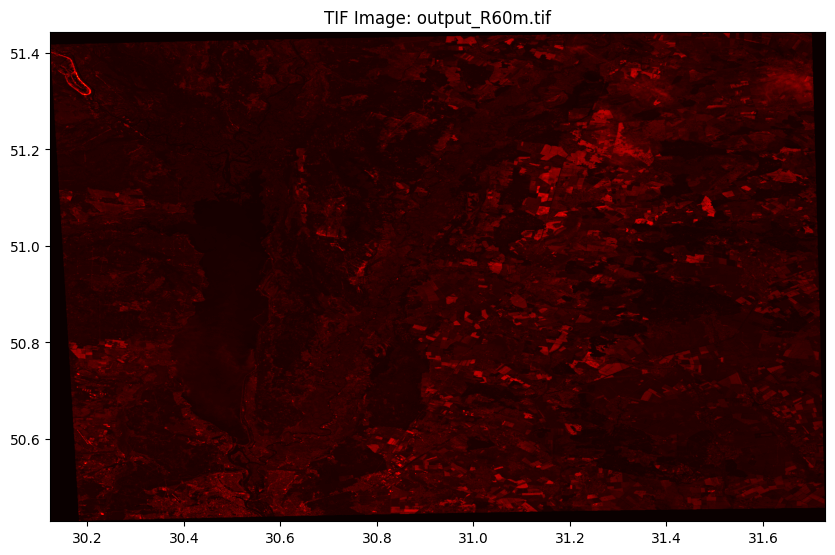

Displaying output_R20m.tif


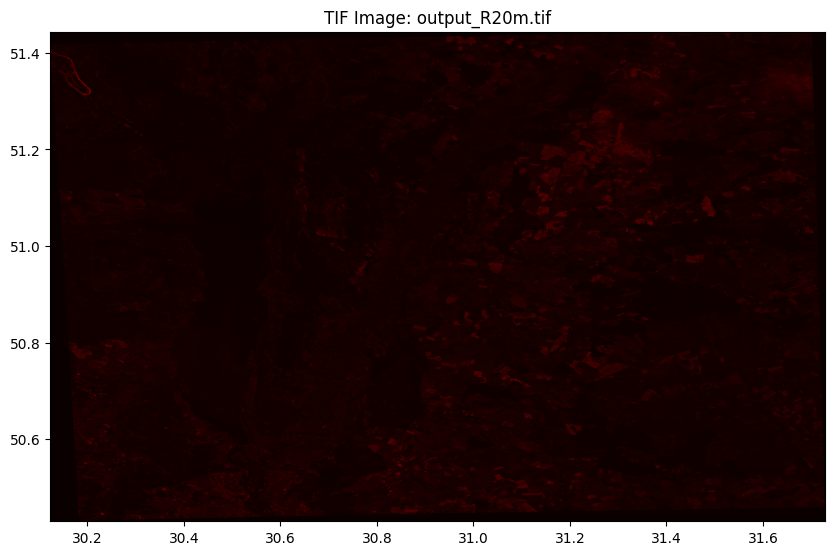

In [29]:
display_tif_images('./reproject_L2A_B', cmap='hot') 

<h3>This was the second reprojection by identifier <i>S2A_MSIL2A_20190821T085601_N0213_R007_T36UUB_20190821T115206</i></h3>

===========================================================================================================================================

<h3>– Конкатенація всіх отриманих растрів у один 4-канальний файл TIFF.</h3>

<h3>Code</h3>

In [36]:
def concatenate_all(directory_A, directory_B, output_file='output_4.tif'):
    # Перевірка існування директорій
    if not os.path.exists(directory_A) or not os.path.exists(directory_B):
        print("One or both directories do not exist.")
        return

    # Збір всіх файлів .tif з обох директорій
    tif_files = []
    for directory in [directory_A, directory_B]:
        for filename in os.listdir(directory):
            if filename.endswith('.tif'):
                tif_files.append(os.path.join(directory, filename))
    
    # Використання gdal_merge.py для конкатенації
    gdal_merge_command = ['gdal_merge.py', '-o', output_file] + tif_files
    os.system(' '.join(gdal_merge_command))

    print(f"Concatenated file created: {output_file}")

<h3>Let's call the function....</h3>

In [33]:
directory_A = "./reproject_L2A_A"
directory_B = "./reproject_L2A_B"
output_file = "output_4.tif"
concatenate_all(directory_A, directory_B, output_file)

0...10...20...30...40...50...60...70...80...90...100 - done.
Concatenated file created: output_4.tif


<h3>Concatenated redesigned grow: <i>output_4.tif</i></h3>

<h3>Show with <i>rasterio</i></h3>

In [8]:
def open_and_display_tif(tif_file, cmap='viridis'):
    try:
        # Відкриття файлу .tif за допомогою rasterio
        with rasterio.open(tif_file) as dataset:
            # Відображення зображення з вказаною колірною схемою            
            print(f"Displaying {tif_file}")
            fig, ax = plt.subplots(figsize=(10, 8))
            show(dataset, ax=ax, cmap=cmap)
              
            # Додаємо підпис до картинки
            ax.set_title(f"TIF Image: {tif_file}")
                
            plt.show()
            
    except Exception as e:
        print(f"An error occurred while opening the TIFF file: {e}")

<h3>Showing....</h3>

Displaying output_4.tif


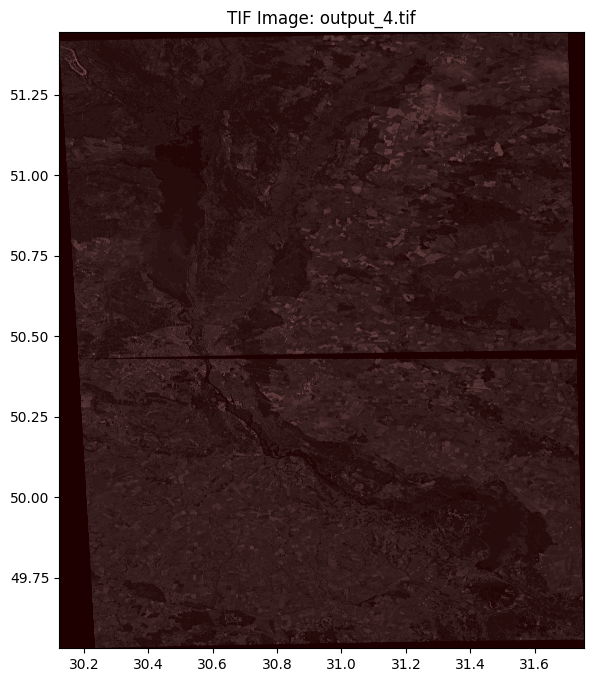

In [6]:
open_and_display_tif('output_4.tif', cmap='pink')  

===========================================================================================================================================

In [35]:
directory_A = "./concat_L2A_A/concatenated"
directory_B = "./concat_L2A_B/concatenated"
output_file = "output_not_reproj_4.tif"
concatenate_all(directory_A, directory_B, output_file)

0...10...20...30...40...50...60...70...80...90...100 - done.
Concatenated file created: output_not_reproj_4.tif


<h3>Concatenated not reengineered grow: <i>output_not_reproj_4.tif</i></h3>

<h3>Showing....</h3>

Displaying output_not_reproj_4.tif


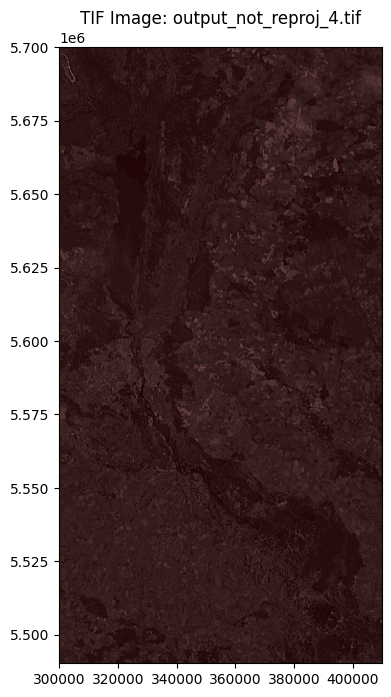

In [7]:
open_and_display_tif('output_not_reproj_4.tif', cmap='pink')  

===========================================================================================================================================

<h3>– Обрізання результуючого зображення по заданому векторному контуру.</h3>

In [2]:
def gdalwarp_cutline(input_image, output_image, shapefile):
    try:
        # Формування команди gdalwarp для обрізання за вказаним векторним контуром
        command = f"gdalwarp -cutline {shapefile} -crop_to_cutline {input_image} {output_image}"
        subprocess.run(command, shell=True, check=True)        
        
        print("Image successfully cropped using gdalwarp.")
    except subprocess.CalledProcessError as e:
        print(f"An error occurred while cropping the image using gdalwarp: {e}")

In [23]:
input_image = "output_4.tif"
output_image = "output_4_cutted.tif"
shapefile = "./GUI_data/Kyiv_regions.shp"
gdalwarp_cutline(input_image, output_image, shapefile)

Creating output file that is 4834P x 3172L.
Processing output_4.tif [1/1] : 0...10...20...30...40...50...60...70...80...90...100 - done.
Image successfully cropped using gdalwarp.


<h3>Showing.....</h3>

Displaying output_4_cutted.tif


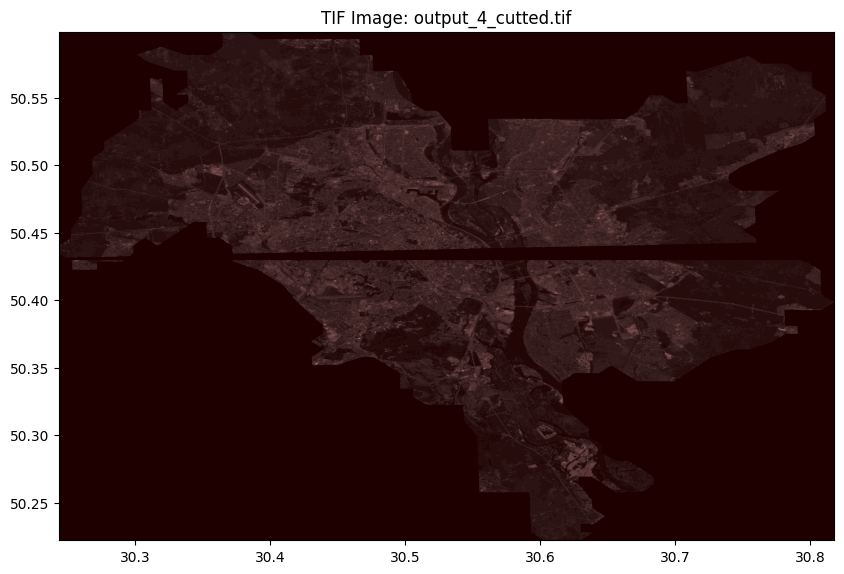

In [24]:
open_and_display_tif('output_4_cutted.tif', cmap='pink')  

In [25]:
input_image = "output_not_reproj_4.tif"
output_image = "output_not_reproj_4_cutted.tif"
shapefile = "./GUI_data/Kyiv_regions.shp"
gdalwarp_cutline(input_image, output_image, shapefile)

Creating output file that is 4067P x 4251L.
Processing output_not_reproj_4.tif [1/1] : 0...10...20...30...40...50...60...70...80...90...100 - done.
Image successfully cropped using gdalwarp.


Displaying output_not_reproj_4_cutted.tif


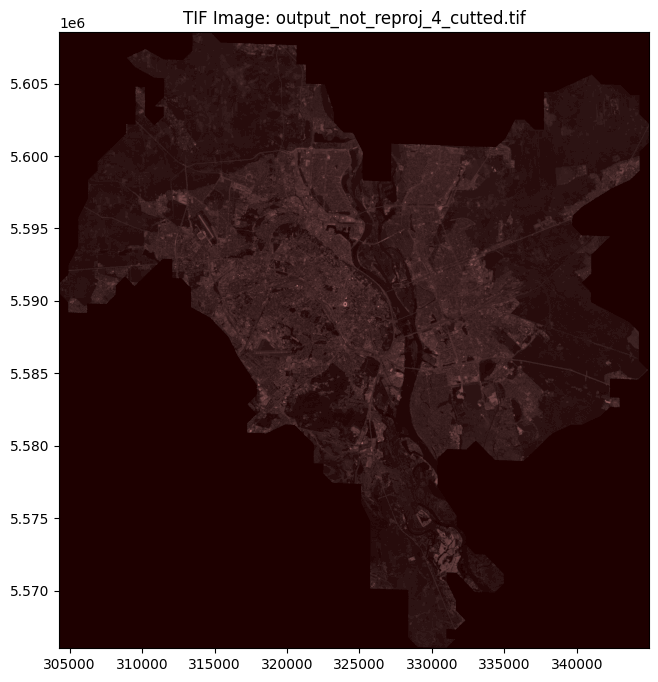

In [26]:
open_and_display_tif('output_not_reproj_4_cutted.tif', cmap='pink')  

<h3>At this stage, we received a cropped image that was previously reprojected and concatenated: <i>output_4_cutted.tif</i></h3>

======================================================================================================================================================

<h4>Іншу частину лабораторної роботи можна знайти у <i>workspace_7_2</i>...............</h4>